# Homework 3 - Deep Domain Adaptation

Artificial Intelligence and Machine Learning  
Loparco Enrico - s261072

## Table of Contents
* [1. The Dataset](#dataset)
* [2. Implementing the Model](#model)
* [3. Train and Test without Validation](#wo-validation)
    + [3A. Without Adaptation](#wo-validation-wo-adaptation)
    + [3B. With Adaptation](#wo-validation-w-adaptation)
* [4. Train and Test with Validation](#w-validation)
    + [4A. Without Adaptation](#w-validation-wo-adaptation)
    + [4B. With Adaptation](#w-validation-w-adaptation)


**Install requirements**

In [2]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [3]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import math

# Set seed to get reproducible results
SEED = 42 
torch.manual_seed(SEED)

**Set Starting Arguments**

In [0]:
DEVICE = 'cuda'
BATCH_SIZE = 256
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 20
STEP_SIZE = 20
GAMMA = 0.1

## 1. The Dataset <a name="dataset"></a>

**Define Data Preprocessing**

In [0]:
# Define transform
transform = transforms.Compose([transforms.Resize(256),             # Resizes short size of the PIL image to 256
                                transforms.CenterCrop(224),         # Crops a central square patch of the image
                                                                    # 224 because torchvision's AlexNet needs a 224x224 input!
                                transforms.ToTensor(),              # Turn PIL Image to torch.Tensor
                                transforms.Normalize(               # Normalize input images using ImageNet's mean and standard deviation
                                          mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

**Prepare Dataset**

In [7]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git

DATA_DIR = 'Homework3-PACS/PACS'

# Prepare Pytorch train/test Datasets
source_dataset = torchvision.datasets.ImageFolder(DATA_DIR + '/photo', transform=transform)
target_dataset = torchvision.datasets.ImageFolder(DATA_DIR + '/art_painting', transform=transform)
target_dataset_validation_cartoon = torchvision.datasets.ImageFolder(DATA_DIR + '/cartoon', transform=transform)
target_dataset_validation_sketch = torchvision.datasets.ImageFolder(DATA_DIR + '/sketch', transform=transform)

# Check dataset sizes
print('Train Dataset (photo):\t\t{}'.format(len(source_dataset)))
print('Test Dataset (art_painting):\t{}'.format(len(target_dataset)))
print('Validation Dataset 1 (cartoon):\t{}'.format(len(target_dataset_validation_cartoon)))
print('Validation Dataset 2 (sketch):\t{}'.format(len(target_dataset_validation_sketch)))

Train Dataset (photo):		1670
Test Dataset (art_painting):	2048
Validation Dataset 1 (cartoon):	2344
Validation Dataset 2 (sketch):	3929


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_dataloader_validation_cartoon = DataLoader(target_dataset_validation_cartoon, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)
target_dataloader_validation_sketch = DataLoader(target_dataset_validation_sketch, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

**Show Source Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

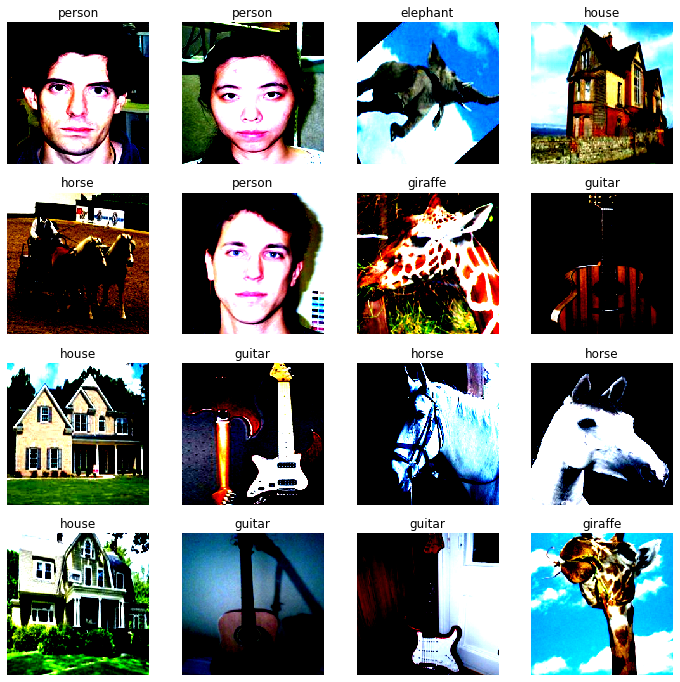

In [6]:
# Get some random source images
dataiter = iter(source_dataloader)
images, labels = dataiter.next()

# Plot a few images after transformation
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(16):
    ax = axes[i//4, i%4]
    ax.imshow(images[i].permute(1,2,0))
    ax.set_title({k for k, v in source_dataset.class_to_idx.items() if v == labels[i]}.pop())
    ax.axis('off')

**Show Target Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

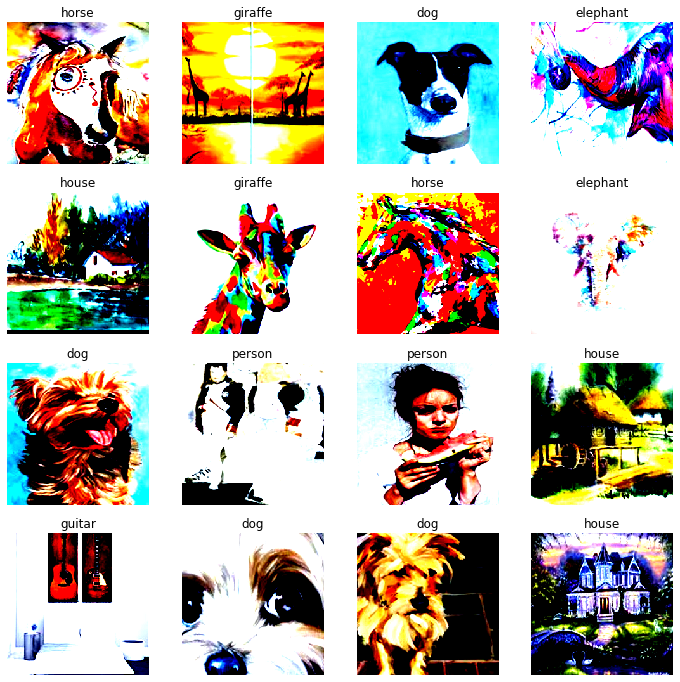

In [7]:
# Get some random target images
dataiter = iter(target_dataloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
    ax = axes[i//4, i%4]
    ax.imshow(images[i].permute(1,2,0))
    ax.set_title({k for k, v in target_dataset.class_to_idx.items() if v == labels[i]}.pop())
    ax.axis('off')

## 2. Implementing the Model <a name="model"></a>

**Prepare Network**

In [0]:
import torch.utils.model_zoo as model_zoo
from torch.autograd import Function

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class DANN(nn.Module):
    def __init__(self, num_classes=1000):
        super(DANN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.dann_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x, alpha=None):
        # If we pass alpha, we can assume we are training the discriminator
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            x = self.features(x)
            x = ReverseLayerF.apply(x, alpha)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            discriminator_output = self.dann_classifier(x)
            return discriminator_output
        # If we don't pass alpha, we assume we are training with supervision
        else:
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            class_outputs = self.classifier(x)
            return class_outputs

def dann(num_classes=7, num_domains=2, pretrained=False, progress=True, **kwargs):
    r"""
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = DANN(**kwargs)

    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']), strict=False)
        model.dann_classifier[1].weight.data = model.classifier[1].weight.data
        model.dann_classifier[1].bias.data = model.classifier[1].bias.data
        model.dann_classifier[4].weight.data = model.classifier[4].weight.data
        model.dann_classifier[4].bias.data = model.classifier[4].bias.data
        
    model.classifier[6] = nn.Linear(4096, num_classes)
    model.dann_classifier[6] = nn.Linear(4096, num_domains)

    return model

**Display Network Architecture**

In [10]:
print(dann())

DANN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    

## 3. Train and Test without Validation <a name="wo-validation"></a>

### 3A. Without Adaptation<a name="wo-validation-wo-adaptation"></a>

**Train**

In [0]:
%%time
lr = 1e-3

net = dann(pretrained=True, progress=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE) # By default, everything is loaded to cpu, this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime
losses = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in source_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

  losses.append(loss.item())
  print('Train Loss: {}'.format(loss.item()))
  # Step the scheduler
  scheduler.step() 

Starting epoch 1/20, LR = [0.001]
Train Loss: 0.8088365793228149
Starting epoch 2/20, LR = [0.001]
Train Loss: 0.2605575621128082
Starting epoch 3/20, LR = [0.001]
Train Loss: 0.1879478543996811
Starting epoch 4/20, LR = [0.001]
Train Loss: 0.1409134715795517
Starting epoch 5/20, LR = [0.001]
Train Loss: 0.11894600838422775
Starting epoch 6/20, LR = [0.001]
Train Loss: 0.09525343775749207
Starting epoch 7/20, LR = [0.001]
Train Loss: 0.08754230290651321
Starting epoch 8/20, LR = [0.001]
Train Loss: 0.07897226512432098
Starting epoch 9/20, LR = [0.001]
Train Loss: 0.0742509514093399
Starting epoch 10/20, LR = [0.001]
Train Loss: 0.0584317147731781
Starting epoch 11/20, LR = [0.001]
Train Loss: 0.05766262114048004
Starting epoch 12/20, LR = [0.001]
Train Loss: 0.04769448563456535
Starting epoch 13/20, LR = [0.001]
Train Loss: 0.02875516563653946
Starting epoch 14/20, LR = [0.001]
Train Loss: 0.027840418741106987
Starting epoch 15/20, LR = [0.001]
Train Loss: 0.029452387243509293
Starting

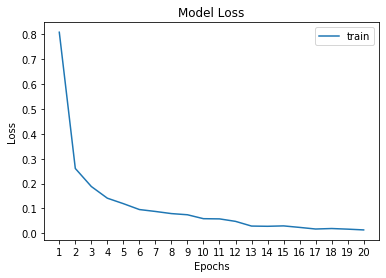

In [0]:
epochs = np.arange(1, NUM_EPOCHS+1)
plt.plot(epochs, losses, label='train')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend();

**Test**

In [0]:
def test(net, dataloader, dataset_size, device):
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(dataset_size)
    print('Test Accuracy: {}'.format(accuracy))

In [0]:
test(net, target_dataloader, len(target_dataset), DEVICE)

100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Test Accuracy: 0.4990234375


### 3B. With Adaptation<a name="wo-validation-w-adaptation"></a>

**Train**

In [15]:
%%time
lr = 0.001
alpha = 0.01

net = dann(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net = net.to(DEVICE)
cudnn.benchmark
net.train()
losses = {'source_class': [], 'source_domain': [], 'target_domain': []}
    
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    for images, labels in source_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()

        # STEP 1: train on source labels by forwarding source data
        outputs = net(images)
        loss_source_class = criterion(outputs, labels)
        loss_source_class.backward()

        # STEP 2: train the discriminator by forwarding source data
        outputs = net(images, alpha=alpha)
        zeros = torch.zeros(len(labels)).long().to(DEVICE)
        loss_source_domain = criterion(outputs, zeros)
        loss_source_domain.backward()

        # STEP 3: train the discriminator by forwarding target data
        images, labels = next(iter(target_dataloader))
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = net(images, alpha=alpha)
        ones = torch.ones(len(labels)).long().to(DEVICE)
        loss_target_domain = criterion(outputs, ones)
        loss_target_domain.backward() 
                          
        optimizer.step() # Update weights based on accumulated gradients

    # Store losses
    losses['source_class'].append(loss_source_class.item())
    losses['source_domain'].append(loss_source_domain.item())
    losses['target_domain'].append(loss_target_domain.item())

    # Print losses
    print('Source Class Loss:\t{}'.format(loss_source_class.item()))    
    print('Source Domain Loss:\t{}'.format(loss_source_domain.item()))         
    print('Target Domain Loss:\t{}'.format(loss_target_domain.item()))         

    scheduler.step()

Starting epoch 1/20, LR = [0.001]
Source Class Loss:	0.7783464193344116
Source Domain Loss:	0.2632668614387512
Target Domain Loss:	0.2336190938949585
Starting epoch 2/20, LR = [0.001]
Source Class Loss:	0.26295799016952515
Source Domain Loss:	0.1588302105665207
Target Domain Loss:	0.2699935734272003
Starting epoch 3/20, LR = [0.001]
Source Class Loss:	0.1344836801290512
Source Domain Loss:	0.19199706614017487
Target Domain Loss:	0.21540957689285278
Starting epoch 4/20, LR = [0.001]
Source Class Loss:	0.14145617187023163
Source Domain Loss:	0.20985393226146698
Target Domain Loss:	0.12866629660129547
Starting epoch 5/20, LR = [0.001]
Source Class Loss:	0.16034913063049316
Source Domain Loss:	0.1403735727071762
Target Domain Loss:	0.11846151947975159
Starting epoch 6/20, LR = [0.001]
Source Class Loss:	0.0846518725156784
Source Domain Loss:	0.16436514258384705
Target Domain Loss:	0.08885878324508667
Starting epoch 7/20, LR = [0.001]
Source Class Loss:	0.07600005716085434
Source Domain Los

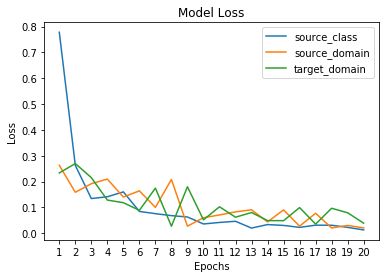

In [16]:
epochs = np.arange(1, NUM_EPOCHS+1)
plt.plot(epochs, losses['source_class'], label='source_class')
plt.plot(epochs, losses['source_domain'], label='source_domain')
plt.plot(epochs, losses['target_domain'], label='target_domain')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend();

**Test**

In [17]:
test(net, target_dataloader, len(target_dataset), DEVICE)

100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Test Accuracy: 0.49072265625


## 4. Train and Test with Validation <a name="w-validation"></a>

### 4A. Without Adaptation<a name="w-validation-wo-adaptation"></a>

**Validation**

In [0]:
def plot_accuracy_and_loss(accuracies, losses, epochs, title):
    fig, ax = plt.subplots(1, 2, figsize=(22, 5))
    epochs = np.arange(1, epochs+1)

    ax[0].plot(epochs, accuracies['train'], label='train')
    ax[0].plot(epochs, accuracies['val'], label='val')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xticks(epochs)
    ax[0].legend()

    ax[1].plot(epochs, losses['train'], label='train')
    ax[1].plot(epochs, losses['val'], label='val')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_xticks(epochs)
    ax[1].legend()
    fig.suptitle(title, fontsize=14)

In [0]:
def train_one_epoch(net, optimizer, dataloader, dataset_size, device, losses, accuracies):
    net.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over the dataset
    for images, labels in dataloader:
        # Bring data over the device of choice
        images = images.to(device)
        labels = labels.to(device)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        with torch.set_grad_enabled(True):
            # Forward pass to the network
            outputs = net(images)
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            # Compute loss based on output and ground truth
            loss = criterion(outputs, labels)

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients
            
        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate Loss and Accuracy
    epoch_loss = running_loss / float(dataset_size)
    epoch_acc = running_corrects.double() / float(dataset_size)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc.item())
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [0]:
def evaluate(net, optimizer, dataloader, dataset_size, device):
    net.eval() # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over the dataset
    for images, labels in dataloader:
        # Bring data over the device of choice
        images = images.to(device)
        labels = labels.to(device)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # disable gradient to save resources (no need to calculate gradient in test phase)
        with torch.set_grad_enabled(False):
            # Forward pass to the network
            outputs = net(images)
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            # Compute loss based on output and ground truth
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate Loss and Accuracy
    epoch_loss = running_loss / float(dataset_size)
    epoch_acc = running_corrects.double() / float(dataset_size)
    return epoch_loss, epoch_acc

Learning rate:0.01
----------------------------------------

Starting epoch 1/20, LR = [0.01]
Train Loss: 0.6826 Acc: 0.6503
Val Loss: 2.5380 Acc: 0.2282

Starting epoch 2/20, LR = [0.01]
Train Loss: 0.1314 Acc: 0.8749
Val Loss: 4.0501 Acc: 0.1923

Starting epoch 3/20, LR = [0.01]
Train Loss: 0.0868 Acc: 0.8940
Val Loss: 2.8479 Acc: 0.3150

Starting epoch 4/20, LR = [0.01]
Train Loss: 0.0506 Acc: 0.9018
Val Loss: 2.7804 Acc: 0.3163

Starting epoch 5/20, LR = [0.01]
Train Loss: 0.0385 Acc: 0.9072
Val Loss: 3.5868 Acc: 0.2563

Starting epoch 6/20, LR = [0.01]
Train Loss: 0.0330 Acc: 0.9120
Val Loss: 3.1611 Acc: 0.3254

Starting epoch 7/20, LR = [0.01]
Train Loss: 0.0153 Acc: 0.9156
Val Loss: 3.5948 Acc: 0.3246

Starting epoch 8/20, LR = [0.01]
Train Loss: 0.0181 Acc: 0.9120
Val Loss: 3.8751 Acc: 0.2884

Starting epoch 9/20, LR = [0.01]
Train Loss: 0.0141 Acc: 0.9150
Val Loss: 3.9301 Acc: 0.2674

Starting epoch 10/20, LR = [0.01]
Train Loss: 0.0147 Acc: 0.9156
Val Loss: 4.8143 Acc: 0.2552

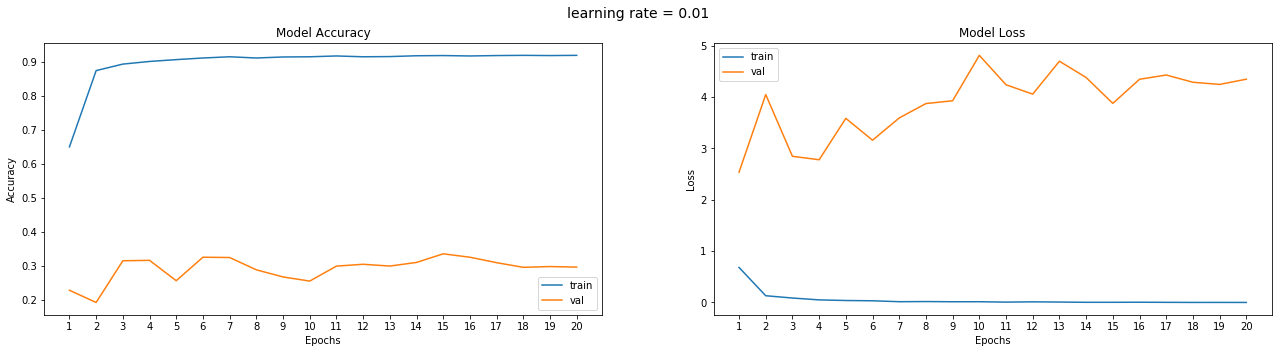

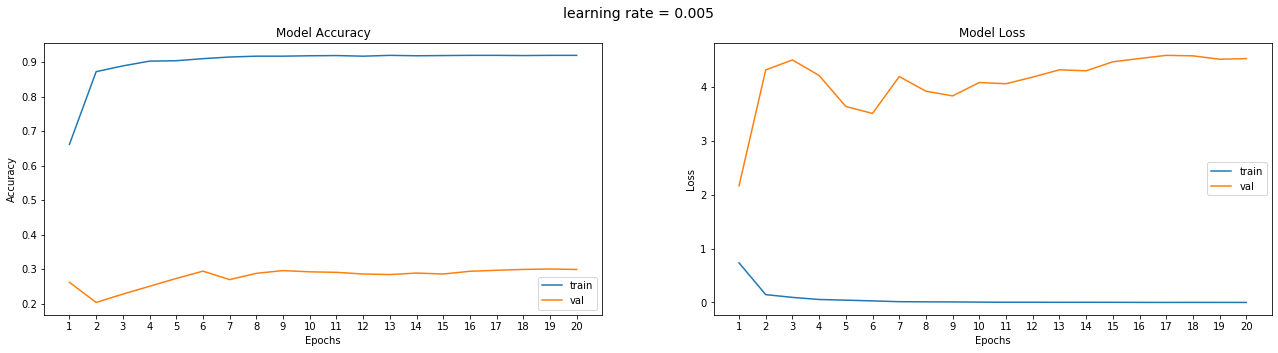

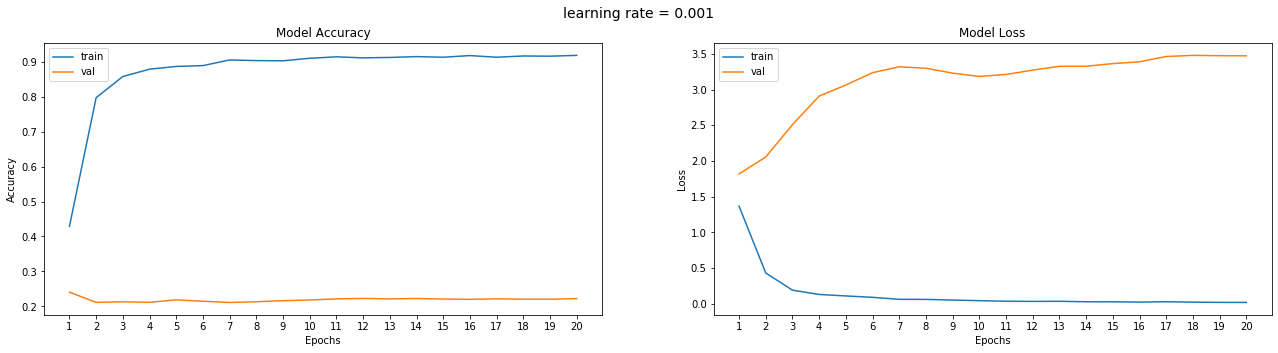

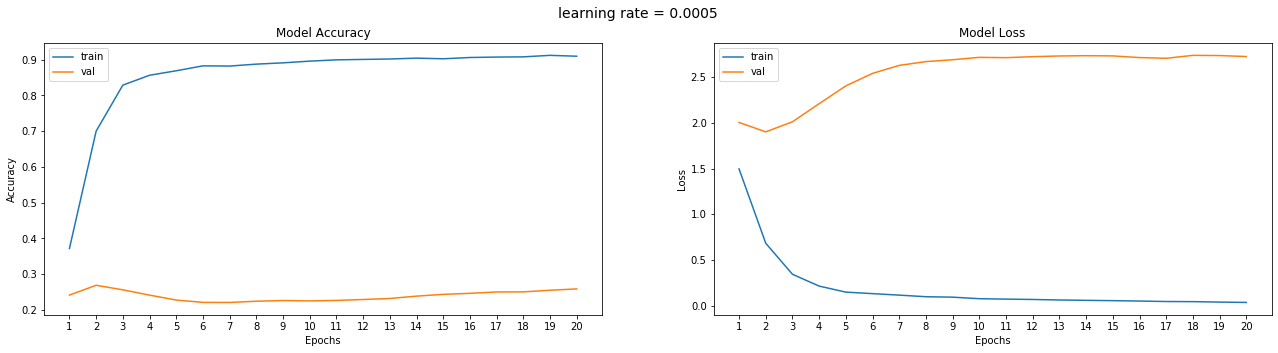

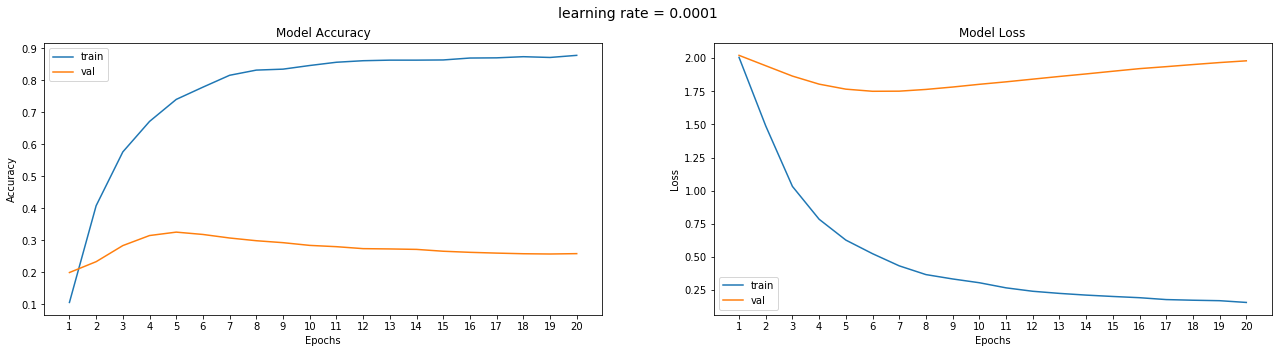

In [0]:
%%time
best_acc = 0.0
lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]

for lr in lrs:
    print(f"Learning rate:{lr}")
    print('-' * 40 + '\n');

    net = dann(pretrained=True, progress=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    net = net.to(DEVICE)

    since = time.time()
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    
    for epoch in range(NUM_EPOCHS):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

        # Train for one epoch
        train_one_epoch(net, optimizer, source_dataloader, len(source_dataset), DEVICE, losses['train'], accuracies['train'])
        # Update the learning rate (learning rate dacay)
        scheduler.step()
        # Evaluate on the validation dataset
        epoch_loss_cartoon, epoch_acc_cartoon = evaluate(net, optimizer, target_dataloader_validation_cartoon, len(target_dataset_validation_cartoon), DEVICE)
        epoch_loss_sketch, epoch_acc_sketch = evaluate(net, optimizer, target_dataloader_validation_sketch, len(target_dataset_validation_sketch), DEVICE)

        # Average loss and accuracy
        epoch_loss = (epoch_loss_cartoon + epoch_loss_sketch) / 2.0
        epoch_acc = (epoch_acc_cartoon + epoch_acc_sketch) / 2.0

        # Store loss and accuracy
        losses['val'].append(epoch_loss)
        accuracies['val'].append(epoch_acc.item())
        print('Val Loss: {:.4f} Acc: {:.4f}\n'.format(epoch_loss, epoch_acc))
        
        # Update best accuracy and learning rate
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_lr = lr

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))

    plot_accuracy_and_loss(accuracies, losses, NUM_EPOCHS, "learning rate = " + str(lr))

In [0]:
print(f"Best lr: {best_lr} (with validation accuracy = {best_acc})")

Best lr: 0.01 (with validation accuracy = 0.3354935124049142)


**Train (with best hyperparameters)**

In [0]:
%%time
lr = best_lr

net = dann(pretrained=True, progress=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE) # By default, everything is loaded to cpu, this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime
losses = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in source_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

  losses.append(loss.item())
  print('Train Loss: {}'.format(loss.item()))
  # Step the scheduler
  scheduler.step() 

Starting epoch 1/20, LR = [0.01]
Train Loss: 0.2257070541381836
Starting epoch 2/20, LR = [0.01]
Train Loss: 0.16002941131591797
Starting epoch 3/20, LR = [0.01]
Train Loss: 0.11164242029190063
Starting epoch 4/20, LR = [0.01]
Train Loss: 0.03692522272467613
Starting epoch 5/20, LR = [0.01]
Train Loss: 0.030697492882609367
Starting epoch 6/20, LR = [0.01]
Train Loss: 0.027094680815935135
Starting epoch 7/20, LR = [0.01]
Train Loss: 0.008655073121190071
Starting epoch 8/20, LR = [0.01]
Train Loss: 0.006864408031105995
Starting epoch 9/20, LR = [0.01]
Train Loss: 0.01568775810301304
Starting epoch 10/20, LR = [0.01]
Train Loss: 0.005501376464962959
Starting epoch 11/20, LR = [0.01]
Train Loss: 0.005565507337450981
Starting epoch 12/20, LR = [0.01]
Train Loss: 0.007638322189450264
Starting epoch 13/20, LR = [0.01]
Train Loss: 0.00211273692548275
Starting epoch 14/20, LR = [0.01]
Train Loss: 0.004037432372570038
Starting epoch 15/20, LR = [0.01]
Train Loss: 0.0009018145501613617
Starting e

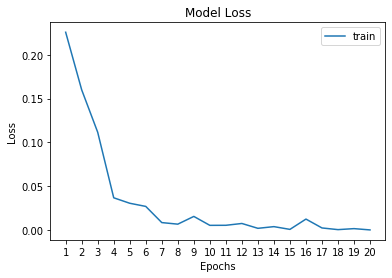

In [0]:
epochs = np.arange(1, NUM_EPOCHS+1)
plt.plot(epochs, losses, label='train')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend();

**Test**

In [0]:
test(net, target_dataloader, len(target_dataset), DEVICE)

100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Test Accuracy: 0.51220703125


### 4B. With Adaptation<a name="w-validation-w-adaptation"></a>

**Validation**

In [0]:
def train_one_dann_epoch(net, optimizer, source_dataloader, target_dataloader, device):
    net.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in source_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # Zero-ing the gradients

        # STEP 1: train on source labels by forwarding source data
        outputs = net(images)
        loss_source_class = criterion(outputs, labels)
        loss_source_class.backward()

        # STEP 2: train the discriminator by forwarding source data
        outputs = net(images, alpha=alpha)
        zeros = torch.zeros(len(labels)).long().to(DEVICE)
        loss_source_domain = criterion(outputs, zeros)
        loss_source_domain.backward()

        # STEP 3: train the discriminator by forwarding target data
        images, labels = next(iter(target_dataloader))
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = net(images, alpha=alpha)
        ones = torch.ones(len(labels)).long().to(DEVICE)
        loss_target_domain = criterion(outputs, ones)
        loss_target_domain.backward() 
                                
        optimizer.step() # Update weights

In [11]:
%%time
NUM_EPOCHS = 8
lrs = [1e-2, 5e-3, 1e-3]
alphas = [0.01, 0.03, 0.05]
best_acc = 0.0

for lr in lrs:
    for alpha in alphas: 
        print(f"Learning rate:{lr} Alpha:{alpha}")
        print('-' * 40 + '\n');

        net1 = dann(pretrained=True, progress=False)
        net2 = dann(pretrained=True, progress=False)
        criterion = nn.CrossEntropyLoss()
        optimizer1 = optim.SGD(net1.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=STEP_SIZE, gamma=GAMMA)
        scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=STEP_SIZE, gamma=GAMMA)
        net1 = net1.to(DEVICE)
        net2 = net2.to(DEVICE)
        cudnn.benchmark

        since = time.time()        
        for epoch in range(NUM_EPOCHS):
            print('Starting epoch {}/{}, LR = {} ALPHA = {}'.format(epoch+1, NUM_EPOCHS, lr, alpha))

            # Train for one epoch
            train_one_dann_epoch(net1, optimizer1, source_dataloader, target_dataloader_validation_cartoon, DEVICE)
            train_one_dann_epoch(net2, optimizer2, source_dataloader, target_dataloader_validation_sketch, DEVICE)
            
            # Update the learning rate (learning rate dacay)
            scheduler1.step()
            scheduler2.step()

            # Evaluate on the validation dataset
            epoch_loss_cartoon, epoch_acc_cartoon = evaluate(net1, optimizer1, target_dataloader_validation_cartoon, len(target_dataset_validation_cartoon), DEVICE)
            epoch_loss_sketch, epoch_acc_sketch = evaluate(net2, optimizer2, target_dataloader_validation_sketch, len(target_dataset_validation_sketch), DEVICE)

            # Average loss and accuracy
            epoch_loss = (epoch_loss_cartoon + epoch_loss_sketch) / 2.0
            epoch_acc = (epoch_acc_cartoon + epoch_acc_sketch) / 2.0

            # Print loss value
            print('Val Loss: {:.4f} Acc: {:.4f}\n'.format(epoch_loss, epoch_acc))
            
            # Update best accuracy and hyperparameters
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_lr = lr
                best_alpha = alpha

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}\n'.format(best_acc))

Learning rate:0.01 Alpha:0.01
----------------------------------------

Starting epoch 1/8, LR = 0.01 ALPHA = 0.01
Val Loss: 3.0584 Acc: 0.2183

Starting epoch 2/8, LR = 0.01 ALPHA = 0.01
Val Loss: 5.2508 Acc: 0.2021

Starting epoch 3/8, LR = 0.01 ALPHA = 0.01
Val Loss: 4.3351 Acc: 0.2548

Starting epoch 4/8, LR = 0.01 ALPHA = 0.01
Val Loss: 4.5726 Acc: 0.2556

Starting epoch 5/8, LR = 0.01 ALPHA = 0.01
Val Loss: 4.1761 Acc: 0.2811

Starting epoch 6/8, LR = 0.01 ALPHA = 0.01
Val Loss: 3.9665 Acc: 0.2972

Starting epoch 7/8, LR = 0.01 ALPHA = 0.01
Val Loss: 4.8676 Acc: 0.2647

Starting epoch 8/8, LR = 0.01 ALPHA = 0.01
Val Loss: 5.3099 Acc: 0.2419

Training complete in 8m 27s
Best val Acc: 0.297191

Learning rate:0.01 Alpha:0.03
----------------------------------------

Starting epoch 1/8, LR = 0.01 ALPHA = 0.03
Val Loss: 3.8360 Acc: 0.2277

Starting epoch 2/8, LR = 0.01 ALPHA = 0.03
Val Loss: 5.2994 Acc: 0.2124

Starting epoch 3/8, LR = 0.01 ALPHA = 0.03
Val Loss: 5.4499 Acc: 0.2535

S

In [26]:
print(f"Best parameters: lr={best_lr}, alpha={best_alpha} (with validation accuracy = {best_acc})")

Best parameters: lr=0.01, alpha=0.03 (with validation accuracy = 0.336515)


**Train (with best hyperparameters)**

In [30]:
%%time
NUM_EPOCHS = 20
lr = best_lr
alpha = best_alpha

net = dann(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net = net.to(DEVICE)
cudnn.benchmark
net.train()
losses = {'source_class': [], 'source_domain': [], 'target_domain': []}
    
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    for images, labels in source_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()

        # STEP 1: train on source labels by forwarding source data
        outputs = net(images)
        loss_source_class = criterion(outputs, labels)
        loss_source_class.backward()

        # STEP 2: train the discriminator by forwarding source data
        outputs = net(images, alpha=alpha)
        zeros = torch.zeros(len(labels)).long().to(DEVICE)
        loss_source_domain = criterion(outputs, zeros)
        loss_source_domain.backward()

        # STEP 3: train the discriminator by forwarding target data
        images, labels = next(iter(target_dataloader))
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = net(images, alpha=alpha)
        ones = torch.ones(len(labels)).long().to(DEVICE)
        loss_target_domain = criterion(outputs, ones)
        loss_target_domain.backward() 
                          
        optimizer.step() # Update weights based on accumulated gradients

    # Store losses
    losses['source_class'].append(loss_source_class.item())
    losses['source_domain'].append(loss_source_domain.item())
    losses['target_domain'].append(loss_target_domain.item())

    # Print losses
    print('Source Class Loss:\t{}'.format(loss_source_class.item()))    
    print('Source Domain Loss:\t{}'.format(loss_source_domain.item()))         
    print('Target Domain Loss:\t{}'.format(loss_target_domain.item()))         

    scheduler.step()

Starting epoch 1/20, LR = [0.01]
Source Class Loss:	0.19404089450836182
Source Domain Loss:	0.1870904415845871
Target Domain Loss:	0.33028870820999146
Starting epoch 2/20, LR = [0.01]
Source Class Loss:	0.07853585481643677
Source Domain Loss:	0.0951087698340416
Target Domain Loss:	0.5297433733940125
Starting epoch 3/20, LR = [0.01]
Source Class Loss:	0.10742519795894623
Source Domain Loss:	0.13885611295700073
Target Domain Loss:	0.3540487289428711
Starting epoch 4/20, LR = [0.01]
Source Class Loss:	0.10906890034675598
Source Domain Loss:	0.2382003217935562
Target Domain Loss:	0.1202501654624939
Starting epoch 5/20, LR = [0.01]
Source Class Loss:	0.04380974918603897
Source Domain Loss:	0.12109897285699844
Target Domain Loss:	0.1283465176820755
Starting epoch 6/20, LR = [0.01]
Source Class Loss:	0.03559684380888939
Source Domain Loss:	0.03369447961449623
Target Domain Loss:	0.0726064071059227
Starting epoch 7/20, LR = [0.01]
Source Class Loss:	0.0088028684258461
Source Domain Loss:	0.087

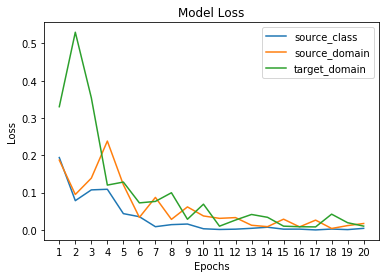

In [31]:
epochs = np.arange(1, NUM_EPOCHS+1)
plt.plot(epochs, losses['source_class'], label='source_class')
plt.plot(epochs, losses['source_domain'], label='source_domain')
plt.plot(epochs, losses['target_domain'], label='target_domain')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend();

**Test**

In [32]:
test(net, target_dataloader, len(target_dataset), DEVICE)

100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Test Accuracy: 0.50439453125
